In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

HF_SHEET = "hedge_fund_series"
MF_SHEET = "merrill_factors"
MONTHS = 12  # monthly data → 12

hf = pd.read_excel('data/proshares_analysis_data.xlsx', sheet_name=HF_SHEET, index_col=0, parse_dates=True)
hf = hf.loc["2011-08":"2025-05"].dropna(how="all").dropna()

In [32]:
# Part 1

mean_ann   = hf.mean() * MONTHS
vol_ann    = hf.std(ddof=1) * np.sqrt(MONTHS)
sharpe_ann = mean_ann / vol_ann  # RF assumed 0%

part1 = pd.DataFrame({
    "Mean (ann)": mean_ann,
    "Vol (ann)": vol_ann,
    "Sharpe (ann)": sharpe_ann
})

print(part1.round(4))

                Mean (ann)  Vol (ann)  Sharpe (ann)
HFRIFWI Index       0.0482     0.0589        0.8189
MLEIFCTR Index      0.0356     0.0556        0.6406
MLEIFCTX Index      0.0337     0.0555        0.6079
HDG US Equity       0.0240     0.0578        0.4154
QAI US Equity       0.0255     0.0500        0.5103


In [33]:
# Part 2

# Skewness & Excess Kurtosis (pandas kurt() is excess kurtosis)
skewness = hf.skew()
ex_kurt  = hf.kurt()

# VaR & CVaR at 5%
q = 0.05
var_5 = hf.quantile(q)

def cvar(series, q=0.05):
    t = series.quantile(q)
    return series[series <= t].mean()

cvar_5 = hf.apply(cvar, q=q)

# Max drawdown + dates
def max_drawdown_with_dates(r):
    r = r.dropna()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0
    mdd = dd.min()
    trough = dd.idxmin()
    peak_date = cum.loc[:trough].idxmax()
    recov = cum.loc[trough:]
    try:
        recovery_date = recov[recov >= peak.loc[peak_date]].index[0]
    except IndexError:
        recovery_date = pd.NaT
    return pd.Series({
        "Max Drawdown": mdd,
        "Peak Date": peak_date,
        "Trough Date": trough,
        "Recovery Date": recovery_date
    })

mdd_df = hf.apply(max_drawdown_with_dates).T  # rows=series
part2 = pd.concat([
    skewness.rename("Skewness"),
    ex_kurt.rename("Excess Kurtosis"),
    var_5.rename("VaR (5%)"),
    cvar_5.rename("CVaR (5%)")
], axis=1).join(mdd_df)

print(part2)

                Skewness  Excess Kurtosis  VaR (5%)  CVaR (5%) Max Drawdown  \
HFRIFWI Index  -0.931719         5.690747 -0.024043  -0.035992    -0.115473   
MLEIFCTR Index -0.251757         1.592585 -0.027482  -0.034993    -0.124302   
MLEIFCTX Index -0.236011         1.547545 -0.027385  -0.034937    -0.124388   
HDG US Equity  -0.238075         1.733096 -0.030347  -0.036831     -0.14072   
QAI US Equity  -0.398593         1.451779 -0.017267  -0.030995    -0.137716   

                          Peak Date          Trough Date        Recovery Date  
HFRIFWI Index   2019-12-31 00:00:00  2020-03-31 00:00:00  2020-08-31 00:00:00  
MLEIFCTR Index  2021-06-30 00:00:00  2022-09-30 00:00:00  2024-02-29 00:00:00  
MLEIFCTX Index  2021-06-30 00:00:00  2022-09-30 00:00:00  2024-02-29 00:00:00  
HDG US Equity   2021-06-30 00:00:00  2022-09-30 00:00:00  2024-07-31 00:00:00  
QAI US Equity   2021-06-30 00:00:00  2022-09-30 00:00:00  2024-02-29 00:00:00  


In [34]:
# Part 3

mf = pd.read_excel('data/proshares_analysis_data.xlsx', sheet_name=MF_SHEET, index_col=0, parse_dates=True)
mf = mf.loc["2011-08":"2025-05"].dropna(how="all").dropna()
spy = mf["SPY US Equity"]

# Align HF with SPY
data = hf.join(spy.rename("SPY"), how="inner").dropna()

# Beta via cov/var (intercept doesn't affect beta)
x = data["SPY"]
betas = data[hf.columns].apply(lambda y: y.cov(x) / x.var(ddof=1))

# Treynor ratio: annualized mean return / beta (RF=0)
treynor_ann = (data[hf.columns].mean() * MONTHS) / betas.replace(0, np.nan)

# Information ratio vs SPY (annualized)
active = data[hf.columns].sub(x, axis=0)
info_ratio_ann = (active.mean() * MONTHS) / (active.std(ddof=1) * np.sqrt(MONTHS))

part3 = pd.DataFrame({
    "Market Beta": betas,
    "Treynor (ann)": treynor_ann,
    "Info Ratio (ann)": info_ratio_ann
})

print(part3.round(4))

                Market Beta  Treynor (ann)  Info Ratio (ann)
HFRIFWI Index        0.3450         0.1398           -0.9083
MLEIFCTR Index       0.3424         0.1041           -1.0484
MLEIFCTX Index       0.3415         0.0988           -1.0664
HDG US Equity        0.3506         0.0685           -1.1723
QAI US Equity        0.3002         0.0850           -1.0877


In [35]:
# Part 4

MONTHS = 12

# SPY summary vs HF (annualized)
spy_stats = pd.Series({
    "Mean (ann)": x.mean() * MONTHS,
    "Vol (ann)": x.std(ddof=1) * np.sqrt(MONTHS),
    "Sharpe (ann)": (x.mean() * MONTHS) / (x.std(ddof=1) * np.sqrt(MONTHS))
}, name="SPY")

hf_sum = pd.concat([
    (hf.mean() * MONTHS).rename("Mean (ann)"),
    (hf.std(ddof=1) * np.sqrt(MONTHS)).rename("Vol (ann)"),
    ((hf.mean() * MONTHS) / (hf.std(ddof=1) * np.sqrt(MONTHS))).rename("Sharpe (ann)")
], axis=1)

print("=== SPY vs Hedge-Fund Series (annualized) ===")
print(pd.concat([spy_stats.to_frame().T, hf_sum]).round(4))

# HDG vs QAI — who has better Sharpe?
hdg_col = "HDG US Equity"
qai_col = "QAI US Equity"
pair = hf_sum.loc[[hdg_col, qai_col]].round(4)
print("\n=== HDG vs QAI (annualized) ===")
print(pair)
better = pair["Sharpe (ann)"].idxmax()
print(f"\nBy Sharpe, better: {better}")

# Do HDG / ML series capture HFRI? Correlation + tracking error vs HFRI
hfri_col = "HFRIFWI Index"
compare = data[[hfri_col]]
for candidate in [hdg_col, qai_col]:
    if candidate in data.columns:
        compare = compare.join(data[[candidate]])

print("\n=== Correlation with HFRI ===")
print(compare.corr().loc[hfri_col].round(4))

for c in compare.columns.drop(hfri_col):
    te_ann = (compare[c] - compare[hfri_col]).std(ddof=1) * np.sqrt(MONTHS)
    print(f"Tracking Error (ann) of {c} vs {hfri_col}: {te_ann:.4f}")

=== SPY vs Hedge-Fund Series (annualized) ===
                Mean (ann)  Vol (ann)  Sharpe (ann)
SPY                 0.1388     0.1445        0.9602
HFRIFWI Index       0.0482     0.0589        0.8189
MLEIFCTR Index      0.0356     0.0556        0.6406
MLEIFCTX Index      0.0337     0.0555        0.6079
HDG US Equity       0.0240     0.0578        0.4154
QAI US Equity       0.0255     0.0500        0.5103

=== HDG vs QAI (annualized) ===
               Mean (ann)  Vol (ann)  Sharpe (ann)
HDG US Equity      0.0240     0.0578        0.4154
QAI US Equity      0.0255     0.0500        0.5103

By Sharpe, better: QAI US Equity

=== Correlation with HFRI ===
HFRIFWI Index    1.0000
HDG US Equity    0.8904
QAI US Equity    0.8562
Name: HFRIFWI Index, dtype: float64
Tracking Error (ann) of HDG US Equity vs HFRIFWI Index: 0.0273
Tracking Error (ann) of QAI US Equity vs HFRIFWI Index: 0.0304


=== Correlation Matrix ===
                HFRIFWI Index  MLEIFCTR Index  MLEIFCTX Index  HDG US Equity  \
HFRIFWI Index           1.000           0.901           0.901          0.890   
MLEIFCTR Index          0.901           1.000           1.000          0.988   
MLEIFCTX Index          0.901           1.000           1.000          0.988   
HDG US Equity           0.890           0.988           0.988          1.000   
QAI US Equity           0.856           0.893           0.893          0.879   
SPY                     0.847           0.890           0.889          0.876   

                QAI US Equity    SPY  
HFRIFWI Index           0.856  0.847  
MLEIFCTR Index          0.893  0.890  
MLEIFCTX Index          0.893  0.889  
HDG US Equity           0.879  0.876  
QAI US Equity           1.000  0.868  
SPY                     0.868  1.000  


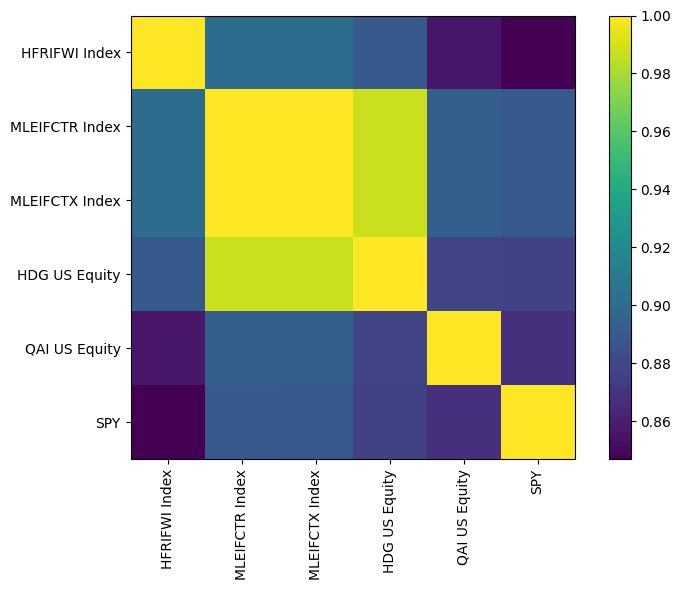


Highest correlation: ('MLEIFCTR Index', 'MLEIFCTX Index') = 1.000
Lowest correlation:  ('HFRIFWI Index', 'SPY') = 0.847


In [36]:
# Part 5

all_df = data[hf.columns.tolist() + ["SPY"]].dropna()
corr = all_df.corr()

print("=== Correlation Matrix ===")
print(corr.round(3))

# Heat map (matplotlib only; single plot)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Highest/lowest correlation pairs (exclude diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = pd.DataFrame(corr.where(mask)).stack()
hi_pair, hi_val = pairs.idxmax(), pairs.max()
lo_pair, lo_val = pairs.idxmin(), pairs.min()
print(f"\nHighest correlation: {hi_pair} = {hi_val:.3f}")
print(f"Lowest correlation:  {lo_pair} = {lo_val:.3f}")

In [37]:
# Part 6
# the regression

factors = pd.read_excel('data/proshares_analysis_data.xlsx', sheet_name=2, index_col=0)
factors.index = pd.to_datetime(factors.index)
hfri_index = pd.read_excel('data/proshares_analysis_data.xlsx', sheet_name=1, index_col=0)[['HFRIFWI Index']]
hfri_index.index = pd.to_datetime(hfri_index.index)

aligned_data = pd.concat([factors, hfri_index], axis=1, join='inner').dropna()

x_factors = aligned_data[factors.columns]
y_dependent = aligned_data["HFRIFWI Index"]

lr = LinearRegression().fit(x_factors, y_dependent)
print("(a)")
print("Betas:")
for i, c in enumerate(factors.columns):
    print(c, ":", lr.coef_[i])
print("intercept :", lr.intercept_)

(a)
Betas:
SPY US Equity : 0.043502780281613584
USGG3M Index : 0.3249305955977181
EEM US Equity : 0.08556408449322507
EFA US Equity : 0.07399440320454796
EUO US Equity : 0.02961413762131762
IWM US Equity : 0.14582428319898907
intercept : 0.0011487727194415239


(b): These betas are realistic position sizes. The USGG3M index is somewhat heavily weighted, but the numbers are not too out of line. 

In [38]:
print(f"(c): R^2: {lr.score(x_factors, y_dependent)}")

(c): R^2: 0.8426938827413941


In [39]:
residuals = y_dependent - lr.predict(x_factors)
print(f"(d): Volatility of residuals: {residuals.std() ** 0.5}")

(d): Volatility of residuals: 0.08204766441887829


In [40]:
# Part 7
factors = pd.read_excel('data/proshares_analysis_data.xlsx', sheet_name=2, index_col=0)
factors.index = pd.to_datetime(factors.index)
hfri_index = pd.read_excel('data/proshares_analysis_data.xlsx', sheet_name=1, index_col=0)[['HFRIFWI Index']]
hfri_index.index = pd.to_datetime(hfri_index.index)

In [41]:
def rolling_regression_replication(factors, hfri_index, window=60):
    """
    rolling 60-month regression to estimate replication values
    
    Parameters:
    factors: factor returns
    hfri_index: HFRI index returns
    window: rolling window size (default 60 months)
    
    Returns:
    DataFrame with replication values and regression stats
    """
    
    aligned_data = pd.concat([factors, hfri_index], axis=1, join='inner')
    
    # drop na
    aligned_data = aligned_data.dropna()
    
    # Initialize results
    replication_values = []
    alphas = []
    betas = []
    r_squared = []
    dates = []
    
    # Start from t=61 (index 60) bc we need 60 months of prior data
    for t in range(window, len(aligned_data)):
        # Get the window data (t-60 to t-1)
        window_data = aligned_data.iloc[t-window:t]
        
        # Separate X and y
        X = window_data.iloc[:, :-1].values
        y = window_data.iloc[:, -1].values
        
        # Fit
        model = LinearRegression()
        model.fit(X, y)
        
        # Get current period factor values (time t)
        current_factors = aligned_data.iloc[t, :-1].values.reshape(1, -1)
        
        # Calculate replication value using estimated parameters
        replication_value = model.predict(current_factors)[0]
        
        # Calculate R**2
        y_pred = model.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        # Store res
        replication_values.append(replication_value)
        alphas.append(model.intercept_)
        betas.append(model.coef_)
        r_squared.append(r2)
        dates.append(aligned_data.index[t])
    
    # aggregate the results
    results = pd.DataFrame({
        'Date': dates,
        'Replication_Value': replication_values,
        'Alpha': alphas,
        'R_Squared': r_squared
    })
    
    # Add beta coefficients as separate columns
    beta_df = pd.DataFrame(betas, columns=factors.columns)
    results = pd.concat([results, beta_df], axis=1)
    
    results.set_index('Date', inplace=True)
    
    return results

In [42]:
# Execute the rolling regression
rolling_results = rolling_regression_replication(factors, hfri_index, window=60)

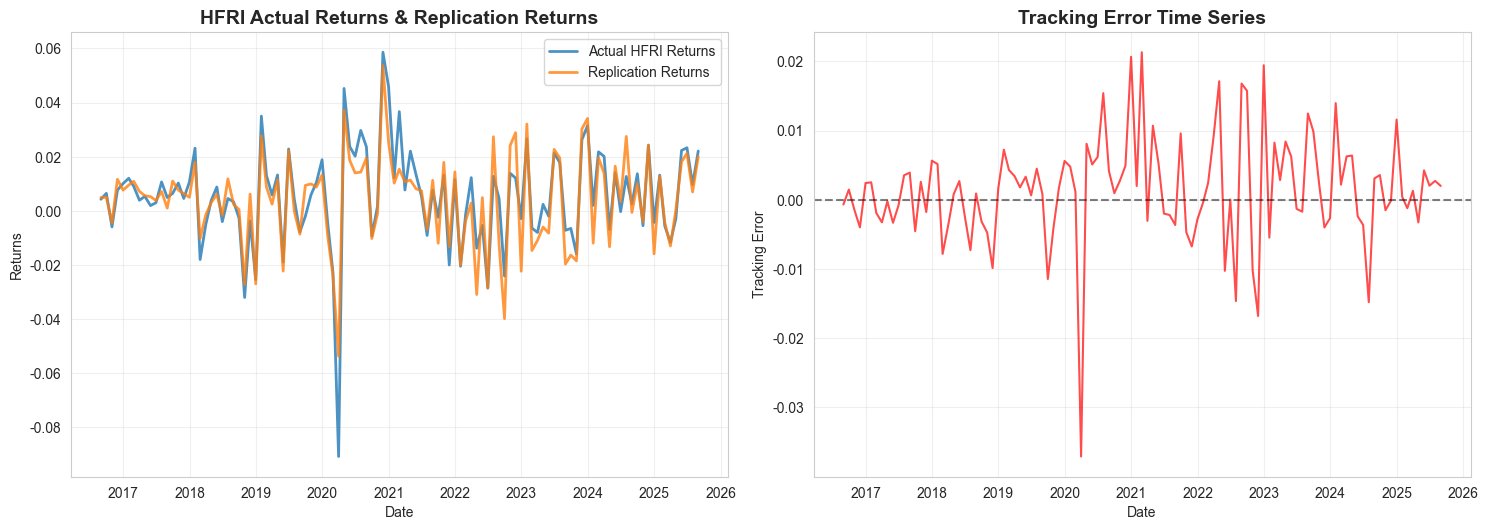

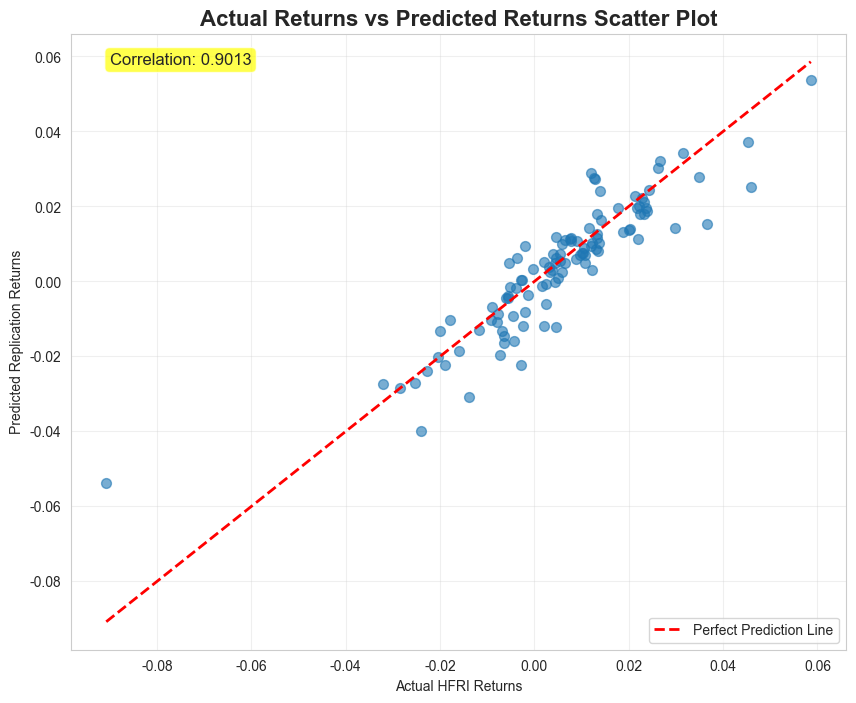

In [43]:
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# actual and predicted values
actual_values = hfri_index.loc[rolling_results.index, 'HFRIFWI Index']
predicted_values = rolling_results['Replication_Value']

# Calculate tracking error
tracking_errors = actual_values - predicted_values

tracking_df = pd.DataFrame({
    'Date': rolling_results.index,
    'Actual': actual_values,
    'Predicted': predicted_values,
    'Tracking_Error': tracking_errors,
    'Abs_Tracking_Error': np.abs(tracking_errors)
})

# 1. Time Series Plots
plt.figure(figsize=(15, 10))

# Subplot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
plt.plot(tracking_df['Date'], tracking_df['Actual'], label='Actual HFRI Returns', linewidth=2, alpha=0.8)
plt.plot(tracking_df['Date'], tracking_df['Predicted'], label='Replication Returns', linewidth=2, alpha=0.8)
plt.title('HFRI Actual Returns & Replication Returns', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Tracking Error Time Series
plt.subplot(2, 2, 2)
plt.plot(tracking_df['Date'], tracking_df['Tracking_Error'], color='red', linewidth=1.5, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Tracking Error Time Series', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Tracking Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(tracking_df['Actual'], tracking_df['Predicted'], alpha=0.6, s=50)
plt.plot([tracking_df['Actual'].min(), tracking_df['Actual'].max()], 
         [tracking_df['Actual'].min(), tracking_df['Actual'].max()], 
         'r--', linewidth=2, label='Perfect Prediction Line')
plt.title('Actual Returns vs Predicted Returns Scatter Plot', fontsize=16, fontweight='bold')
plt.xlabel('Actual HFRI Returns')
plt.ylabel('Predicted Replication Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# correlation coefficient
correlation = tracking_df['Actual'].corr(tracking_df['Predicted'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.show()